In [10]:
import pandas as pd 
import numpy as np 
import tensorflow as tf
import tensorflow_io as tfio
import matplotlib.pyplot as plt
import vlc
from tqdm import tqdm

In [11]:
train = pd.read_csv('data/en/train.tsv', sep='\t')
train = train[['client_id', 'path', 'age', 'gender', 'sentence']].dropna()
train = train[train['gender'] != 'other']

In [12]:
train.shape

(322504, 5)

In [13]:
print(train.shape[0]/train['client_id'].nunique())
print()

46.87558139534884



In [14]:
train.columns

Index(['client_id', 'path', 'age', 'gender', 'sentence'], dtype='object')

## Made small random subset of data that 

In [15]:
indices = np.arange(train.shape[0])
np.random.seed(5)
np.random.shuffle(indices)
small_data = indices[:train.shape[0]//10]  # 10% of original data set for performance reasons 
train = train.iloc[small_data,:]
train.shape

(32250, 5)

In [16]:
# from modules.DataPreprocessor import DataLoader
# dl = DataLoader()
# lengths = []

# for case_num in tqdm(small_data):
#     lengths.append(len(dl.load_audio_binary(case_num)))
# train['length'] = lengths
# train = train[train['length']<500000]
# train.to_csv('small_data.csv')

In [20]:
train = pd.read_csv('small_data.csv')

(array([1.7700e+03, 1.0252e+04, 1.2151e+04, 6.2440e+03, 1.7000e+03,
        1.3200e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([ 79488. , 160819.2, 242150.4, 323481.6, 404812.8, 486144. ,
        567475.2, 648806.4, 730137.6, 811468.8, 892800. ]),
 <BarContainer object of 10 artists>)

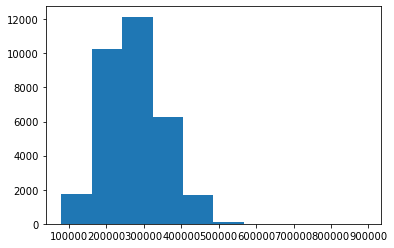

In [22]:
plt.hist(train['length'])

In [48]:
windows_length = 0
for length in train['length']:
    windows_length += (length//64)//32
windows_length

4290131

In [31]:
sum(train['length'])*2

17634419712

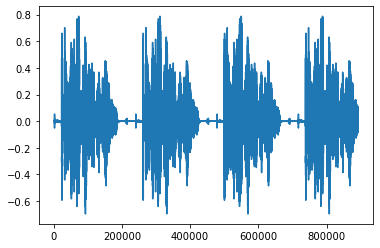

In [19]:
path = str('data/en/clips/' + train['path'].iloc[15276])
audio_binary = tf.io.read_file(path)
audio = np.squeeze(tfio.audio.decode_mp3(audio_binary))
max_len = train['length'].max()
pading = max_len-len(audio)
audio = np.pad(audio, pad_width=(0,pading), mode='wrap')
plt.plot(audio)

In [92]:
audio[:,0]

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [41]:
def show_and_play(case_num):
    
    def power_to_db(S, amin=1e-16, top_db=80.0):   
        #Based on:
        #https://librosa.github.io/librosa/generated/librosa.core.power_to_db.html    
        def _tf_log10(x):
            numerator = tf.math.log(x)
            denominator = tf.math.log(tf.constant(10, dtype=numerator.dtype))
            return numerator / denominator
        
        # Scale magnitude relative to maximum value in S. Zeros in the output 
        # correspond to positions where S == ref.
        ref = tf.reduce_max(S)

        log_spec = 10.0 * _tf_log10(tf.maximum(amin, S))
        log_spec -= 10.0 * _tf_log10(tf.maximum(amin, ref))

        log_spec = tf.maximum(log_spec, tf.reduce_max(log_spec) - top_db)

        return log_spec
    path = str('data/en/clips/' + train['path'].iloc[case_num])
    audio_binary = tf.io.read_file(path)
    audio = tfio.audio.decode_mp3(audio_binary)
    audiofft = tf.signal.stft( tf.squeeze(audio), frame_length=2048, frame_step=64)
    print(audio.shape)
    print(audiofft.shape)
    fftabs = tf.transpose(tf.math.abs(audiofft))
    log_fft = power_to_db(fftabs)

    fig, ax = plt.subplots(figsize=(16, 5))
    ax.imshow(log_fft, cmap='plasma', interpolation='nearest', aspect='auto')
    plt.gca().invert_yaxis()
    ax.set_yscale('symlog')
    print('Recording:\t', case_num, '/', train.shape[0]-1)
    print('Client ID:\t', train['client_id'].iloc[case_num])
    print('Sentence:\t', train['sentence'].iloc[case_num])
    print('Age:\t\t', train['age'].iloc[case_num])
    print('Gender:\t\t', train['gender'].iloc[case_num])

    p = vlc.MediaPlayer(path)
    p.play()

(442368, 1)
(6881, 1025)
Recording:	 31708 / 32249
Client ID:	 372293e65cdab88771e028a4351651ab2eff64438ddafc211e089247dcdccca350153465eb5409ce708081d9ad384af45d1dc57bbe030ae1a2c0edd561322fb8
Sentence:	 Anna asks her servant Cesca to foretell her unborn child's future.
Age:		 fourties
Gender:		 male


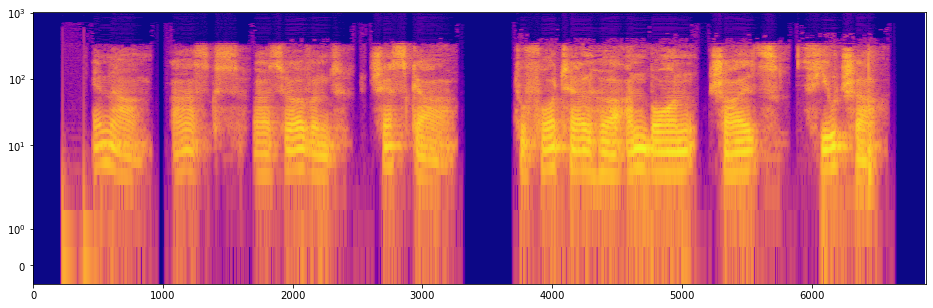

In [42]:
show_and_play(31708)

In [74]:
(train['age'].value_counts()/(train['age'].shape[0]+1))*100

twenties     36.994202
thirties     19.959071
fourties     17.109547
sixties      11.115934
fifties       6.895910
teens         6.654057
seventies     1.097640
eighties      0.161235
nineties      0.009302
Name: age, dtype: float64

In [75]:
train['age'].map({'teens':0, 'twenties':1, 'seventies':2, 'fifties':3, 'fourties':4,
       'thirties':5, 'sixties':6, 'eighties':7, 'nineties':8}).unique()

array([1, 4, 5, 0, 6, 3, 2, 7, 8], dtype=int64)

In [76]:
train['gender'].map({'male':0, 'female':1}).unique()

array([0, 1], dtype=int64)

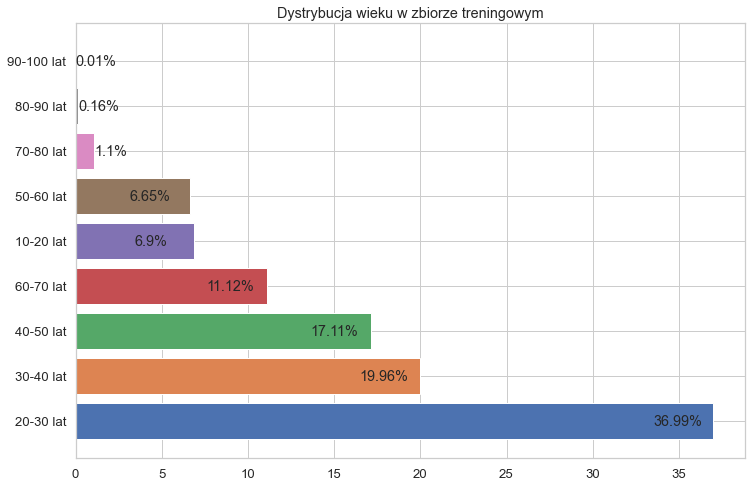

In [77]:
import seaborn as sns
sns.set(font_scale=1.2, style='whitegrid')
colors = sns.color_palette()

labels = ['20-30 lat', '30-40 lat', '40-50 lat', '60-70 lat', '10-20 lat', '50-60 lat', '70-80 lat', '80-90 lat', '90-100 lat']
values = (train['age'].value_counts()/(train['age'].shape[0]+1))*100

fig, ax = plt.subplots(figsize=(12, 8))
ax.barh(
    labels,
    values,
    color=(colors[0], colors[1], colors[2], colors[3], colors[4], colors[5], colors[6], colors[7], colors[8])
    )
ax.set(title='Dystrybucja wieku w zbiorze treningowym')
for index, value in enumerate(values):
    if value>5:
        ax.text(value-3.5, index-0.1, str(np.round(value, 2))+'%')
    else:
        ax.text(value, index-0.1, str(np.round(value, 2))+'%')

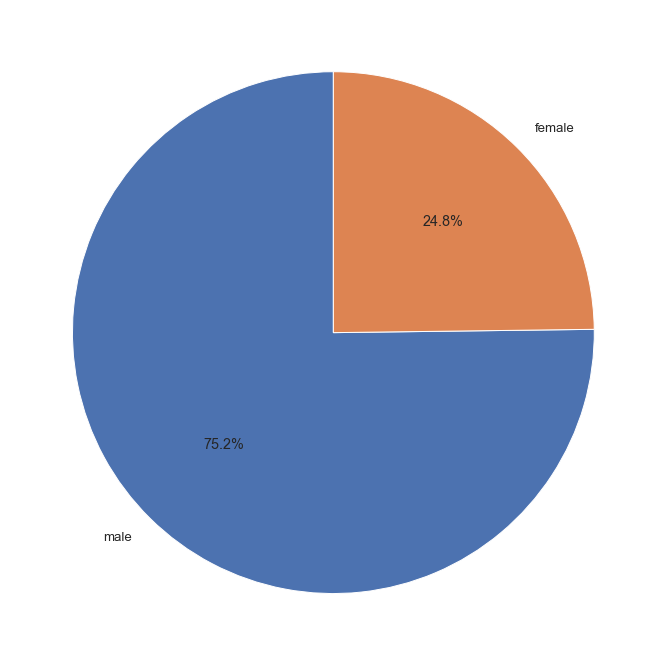

In [78]:
fig, ax = plt.subplots(figsize=(12, 12))
ax.pie(train['gender'].value_counts(), labels=train['gender'].value_counts().index, autopct='%1.1f%%',
        shadow=False, startangle=90)
plt.show()